In [47]:

# coding: utf-8
import os
import re
import datetime

import _main as pp

import turbodbc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans

sns.set(style="whitegrid")

def to_pivot(df):
    pvt = pd.DataFrame()
    cols = ['Preis_Konkurrenz',
            'Txt_Kurz_Konkurrenz',
            'Txt_Lang_Konkurrenz',
            'Joined_on',
            'Preisdifferenz',
            'Closest', 'Distance']
    for i in cols:
        pvt_ = df.pivot(index='UID', columns='Konkurrenz', values=i)
        pvt_.columns = [i + '_' + j for j in pvt_.columns]
        pvt = pd.concat([pvt, pvt_], axis=1)
    pvt = df.merge(
        pvt, left_on='UID',
        right_index=True)
    pvt.drop(cols, axis=1, inplace=True)
    pvt.drop('Konkurrenz', axis=1, inplace=True)
    pvt.drop_duplicates(inplace=True)
    return pvt.reset_index(drop=True)


def get_companies(df):
    companies = [i[17:] for i in df.columns if i.startswith(
        "Preis_") and not i.endswith("Log")]
    return companies


def prep_df(df):
    companies = get_companies(df)
    df = df.replace({r'\\r': ' ',
                     r'\\n': ' ',
                     '': np.nan}, regex=True)
    for i in df.columns:
        try:
            df[i] = df[i].str.strip()
        except AttributeError:
            print("Warning. {} is not a string column".format(i))
    for j, i in enumerate(companies):
        print("{} Company in data: {}".format(j, i))
    df['Discount_perc'] = (df['GrossSales_LTM'] -
                           df['Sales_LTM']) / df['GrossSales_LTM']
    df['Margin_perc'] = df['Margin_LTM'] / df['Sales_LTM']
    df['ProCasa'] = (df['Art_Txt_Lang']
                      .str.lower()
                      .str.replace(" ", "")
                      .str.contains("procasa"))

    for i in ['GrossSales_LTM', 'Sales_LTM',
              'Margin_LTM', 'Quantity_LTM',
              'ObjectRate', 'CountOfOrders', 'Preis',
              'CountOfCustomers', 'Discount_perc', 'Margin_perc']:
        df[i] = df[i].astype(np.float)
        df[i + '_Log'] = df[i].apply(lambda x: np.log(x + 1))

    df['GrossSales_Caluclated'] = df['Preis'] * df['Quantity_LTM']

    for i in companies:
        df['Preis_Konkurrenz_' +
            i] = df['Preis_Konkurrenz_' + i].astype(np.float)
        df['Preis_Konkurrenz_' + i + '_Log'] = df['Preis_Konkurrenz_' +
            i].apply(lambda x: np.log(x + 1))
        df['Outlier_' + i] = np.nan
        df['GrossSales_Caluclated_' + i] = df['Preis_Konkurrenz_' + i] * \
            df['Quantity_LTM']

    return df


def cluster(df, X=None, tag='', clusters=5, scaler_obj=StandardScaler):
    if tag in df.columns:
        df[tag] = np.nan
    if not X:
        X = df
    else:
        X = df[X]
    norm = scaler_obj()
    normalized = norm.fit_transform(X)
    kmeans = KMeans(
        n_clusters=clusters, random_state=23).fit(normalized)
    df[tag] = kmeans.labels_
    return df


def outlier_detection(df, threshold=1.5):
    companies = get_companies(df)
    for i in companies:
        df_temp = df[['Preis', 'Preis_Konkurrenz_' + i]
            ].replace('', np.nan).dropna(how='any').copy()
        df_temp['Preis'] = df_temp['Preis'].astype(np.float)
        df_temp['Preis_Konkurrenz_' +
            i] = df_temp['Preis_Konkurrenz_' + i].astype(np.float)
        df_temp['Diff'] = df_temp['Preis'] - df_temp['Preis_Konkurrenz_' + i]
        df['Outlier_' + i] = False
        df_temp['Outlier_' + i] = (np.abs(
                df_temp['Diff']) / df_temp['Preis']) > threshold * (
                np.std(df_temp['Diff']) / df_temp['Preis'])
        df.update(df_temp)
    return df


def get_cluster(df, plot=True):
    mapper1 = {0: "Low Margin, Low Sales",
               1: "Low Margin, High Sales",
               2: "High Margin, Low Sales",
               3: "High Margin, High Sales"}

    mapper2 = {0: "Low Quantity, Medium Sales",
               1: "Medium Quantity, High Sales",
               2: "Medium Quantity, Medium Sales",
               3: "High Quantity, High Sales",
               4: "Low Quantity, Low Sales"}

    mapper3 = {0: "Low ObjectRate, Medium Sales",
               1: "Low Sales, High ObjectRate",
               2: "High Sales",
               3: "Low Sales, Low ObjectRate",
               4: "Test, Test",
               5: "Test2, Test2",
               6: "test3, test3",
               7: "test4, test4"}

    for i in [['Margin_perc', 'Sales_LTM_Log', StandardScaler, 4, mapper1],
              ['Quantity_LTM_Log', 'Sales_LTM_Log', StandardScaler, 5, mapper2],
              ['ObjectRate', 'Sales_LTM_Log', StandardScaler, 4, mapper3]]:

        tag = 'Cluster_' + '_'.join(i[:2])

        dfs = df.query(
            "Margin_perc > 0.0001 and Sales_LTM > 100 and Margin_perc < 0.8").copy()
        dfs = dfs.pipe(cluster, X=[i[0], i[1]],
                       tag=tag, clusters=i[3], scaler_obj=i[2])
        dfs[tag] = dfs[tag].map(i[4])

        if plot:
            splt = sns.lmplot(i[0], i[1],
                       data=dfs, hue=tag,
                       fit_reg=False, size=7,
                       aspect=1.6,
                       palette=sns.color_palette('colorblind'))
            splt._legend.set_title("Cluster")

            plt.savefig(os.path.join(pp.Path, "Plots", "PDF", tag + ".pdf"))
            plt.savefig(os.path.join(pp.Path, "Plots", "PNG", tag + ".png"))

        df[tag] = np.nan
        df.update(dfs[tag])
    return df


def plot_outlier(df):
    for i in get_companies(df):
        dfplot = df[(df['Joined_on_' + i] != 'Text_Similarity') & (pd.notnull(
            df['Preis_Konkurrenz_' + i]))]
        f, ax = plt.subplots(figsize=(20, 20))
        p1 = sns.regplot('Preis_Konkurrenz_' + i, 'Preis',
                         data=dfplot, fit_reg=False)
        for line in range(0, dfplot.shape[0]):
            if dfplot.Outlier_Sanitas.iloc[line]:
                p1.text(dfplot.Preis_Konkurrenz_Sanitas.iloc[line] + 0.5,
                        dfplot.Preis.iloc[line], dfplot.Art_Txt_Kurz.iloc[line],
                        horizontalalignment='left', size='medium', color='black')
        plt.savefig(os.path.join(pp.Path, "Plots",
                    "PDF", "Outlier_{}.pdf".format(i)))
        plt.savefig(os.path.join(pp.Path, "Plots",
                    "PGN", "Outlier_{}.pgn".format(i)))

In [32]:
query = pp.load_sql_text(os.path.join("SQL", "Sales.sql"))

con = pp.create_connection_string_turbo("CRHBUSADWH02", 'AnalystCM')
meta = pp.sql_to_pandas(con, query)

files = [i for i in os.listdir(os.path.join(
    pp.Path, "Matched")) if i.endswith(".tsv")]
files.sort(reverse=True)
file_ = files[0]

print("Loading and preparing data...")
df = (pd.read_csv(os.path.join(
            pp.Path, "Matched", file_), sep="\t", dtype=str)
        .pipe(to_pivot)
        .merge(meta, how='left', left_on='UID', right_on='UniqueId')
        .pipe(prep_df)
        .drop_duplicates(inplace=False)
        .pipe(outlier_detection, threshold=5))

Loading and preparing data...
Warning. Art_Nr_Hersteller_Firma is not a string column
Warning. GrossSales_LTM is not a string column
Warning. Sales_LTM is not a string column
Warning. Margin_LTM is not a string column
Warning. Quantity_LTM is not a string column
Warning. CountOfOrders is not a string column
Warning. CountOfCustomers is not a string column
0 Company in data: Sabag
1 Company in data: Saneo
2 Company in data: Sanitas
3 Company in data: TeamHug
4 Company in data: TeamKappeler
5 Company in data: TeamMaga
6 Company in data: TeamSaniDusch


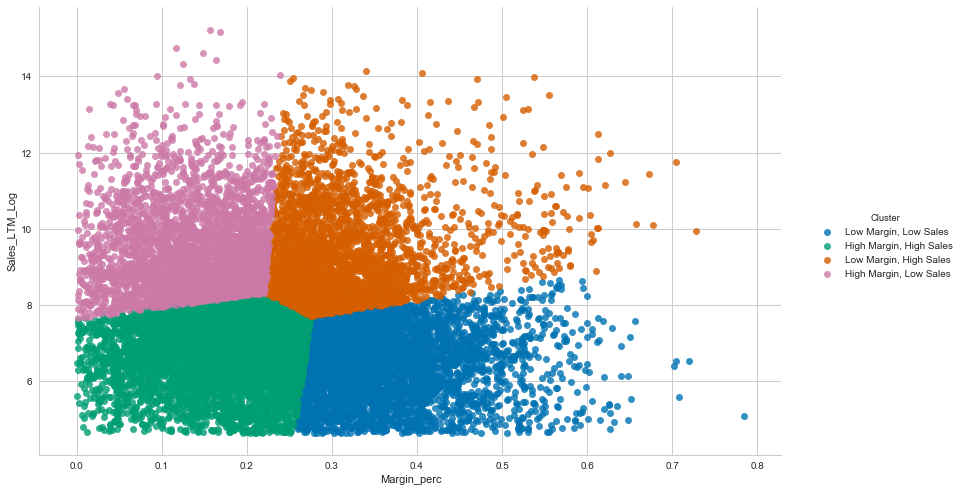

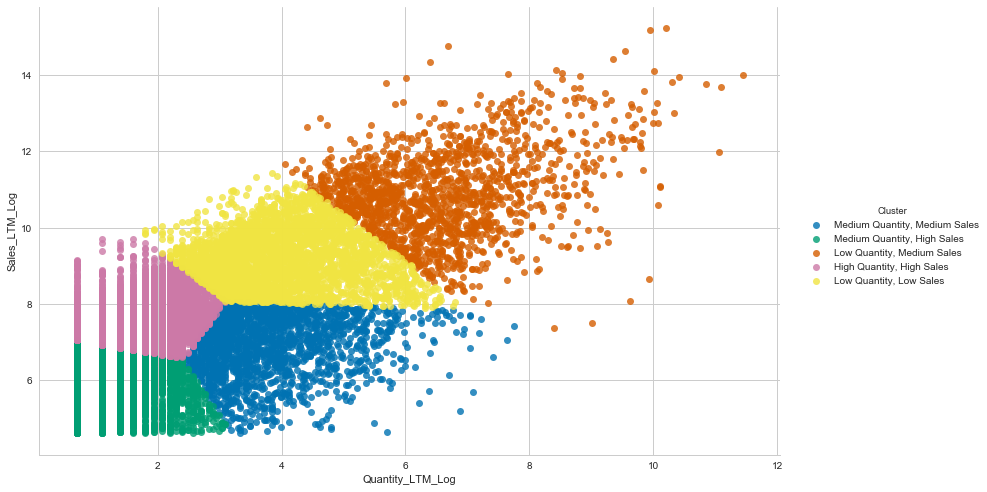

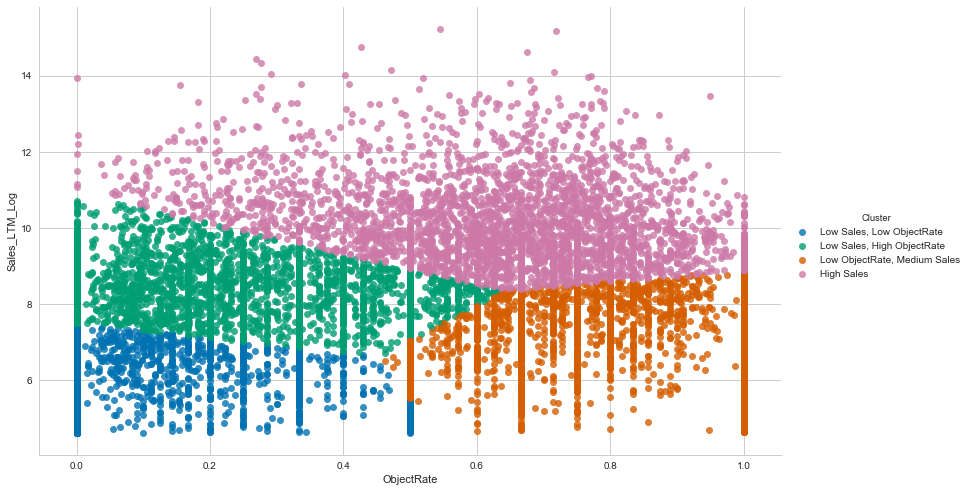

In [48]:
df = df.pipe(get_cluster, plot=True)

In [3]:
dt = datetime.datetime.now()
#df.to_csv(
#    os.path.join(pp.Path, "Analyse",
#        dt.strftime("%Y-%m-%d") + "_Output_Analysis.tsv"),
#    sep="\t", encoding='utf-8', index=True, line_terminator='\n')

In [15]:
for i in df.loc[0:200, 'Art_Txt_Lang'].str.replace('"', ""):
    print(i)

Tauchrohr TECEdrainline zu Ablauf flach 146 771
Tauchrohr TECEdrainline zu Ablauf Norm 146 772
Tauchrohr TECEdrainline zu Ablauf max und senkrecht 146 773/774
Tauchrohr TECEdrainline zu Ablauf superflach 146 770
Membran-Geruchsverschluss für Ablauf TECEdrainline superflach 146 770
Membran-Geruchsverschluss für Ablauf TECEdrainline superflach 146 771
Membran-Geruchsverschluss für Ablauf TECEdrainline Norm 146 772
Membran-Geruchsverschluss für Ablauf TECEdrainline max und senkrecht 146 773/774
Rinnenkörper JOULIA INLINE für 3-Rohr-Wärmetauscher für raumseitige Montage Länge 83,7 cm
Rinnenkörper JOULIA INLINE für 3-Rohr-Wärmetauscher mit Wandaufkantung für wandseitige Montage, Länge 83,7
Rinnenkörper JOULIA INLINE für 5-Rohr-Wärmetauscher für raumseitige Montage Länge 83,7 cm
Rinnenkörper JOULIA INLINE für 5-Rohr-Wärmetauscher mit Wandaufkantung für wandseitige Montage, Länge 83,7
3-Rohr-Wärmetauscher JOULIA INLINE, Achsmass 63 cm 3 doppelwandige Sicherheitsrohre
5-Rohr-Wärmetauscher JOUL

Befestigungsset für WC-Keramik AQUACLEAN TUMA COMFORT
Designabdeckung AQUACLEAN TUMA COMFORT
Designabdeckung AQUACLEAN TUMA COMFORT
Designabdeckung AQUACLEAN TUMA COMFORT
Designabdeckung AQUACLEAN TUMA COMFORT
Duschdüse AQUACLEAN TUMA COMFORT
Fernbedienung AQUACLEAN TUMA COMFORT
Filter für Durchlauferhitzer AQUACLEAN TUMA COMFORT
Panzerschlauch 3/8-1/2 zu Dusch-WC AQUACLEAN TUMA COMFORT
Panzerschlauch 3/8-1/2 mit Bogen 90°, zu Dusch-WC Aufsatz AQUACLEAN TUMA COMFORT
Stopfen AQUACLEAN TUMA COMFORT
Deckel AQUACLEAN TUMA COMFORT
Wandklosett Keramik AQUACLEAN TUMA COMFORT
Druckfedern GEBERIT zu Fernbetätigung Typ 01 Set à 10 Stück
Duschdüse AQUACLEAN TUMA CLASSIC
Ablaufsieb GEBERIT zu Urinal Preda/Selva Edelstahl
Duftsieb GEBERIT zu Urinal
Mengenregler GEBERIT für Steuereinheit, zu Urinal Preda/Selva, 9 l/min
Schutzklappe GEBERIT zu Dockingstation, zu Urinal Preda/Selva
Spülkastendeckel GEBERIT zu Spülkasten AP128 Zweimengenbetätigung
Spülkastendeckel GEBERIT zu Spülkasten AP128 Zweimengen